## Install Packages

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install facenet-pytorch

In [3]:
# requirements_file_path = "/content/drive/MyDrive/Masters/Prep/Projects/OneShot_JPMC/one-shot-face-recognition/src/requirements.txt"

# !cat "/content/drive/MyDrive/Masters/Prep/Projects/OneShot_JPMC/one-shot-face-recognition/src/requirements.txt" | xargs -n 1 pip install

In [4]:
from facenet_pytorch import MTCNN, InceptionResnetV1, training, fixed_image_standardization
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import zipfile 
import torch
from PIL import Image
from torch.utils.data import Dataset
import torch.optim as optim
from torchvision import transforms
from sklearn.metrics import accuracy_score
import src
from tqdm.notebook import tqdm
from src.utils.celeba_helper import CelebADataset, CelebAClassifier, save_file_names, CelebADatasetTriplet
from src.utils.loss_functions import TripletLoss
from imp import reload
import shutil
from torchsummary import summary

workers = 0 if os.name == 'nt' else 2

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Filtering the label file after MTCNN face extraction (enable if you don't have the updated file)

In [8]:
# orig_mapping_file = 'data/identity_CelebA_train_test_split.txt'
# img_folder = 'data/img_align_celeba_mtcnn'

# label_df = pd.read_csv(orig_mapping_file, header=None, sep=" ", names=["file_name", "person_id", "is_train"])

# count=0
# files = []
# for filename in os.listdir(img_folder):
#     files.append(filename)

# file_names = label_df[label_df["file_name"].isin(files)]
# file_names.to_csv("data/identity_CelebA_train_test_split_mtcnn.txt", sep=" ", index=False, header=False)

# Define CelebA Dataset and Loader

In [6]:
## Load the dataset
# Path to directory with all the images
img_folder = 'data/img_align_celeba_mtcnn'
mapping_file = 'data/identity_CelebA_train_test_split_mtcnn.txt'

# Spatial size of training images, images are resized to this size.
image_size = 160
transform=transforms.Compose([
    transforms.Resize(image_size),
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

# Load the dataset from file and apply transformations
celeba_dataset = CelebADatasetTriplet(img_folder, mapping_file, transform)

Image names size is: 202292


In [74]:
celeba_dataset.test_df.shape

(192135, 3)

In [73]:
celeba_dataset.train_df.shape

(10157, 3)

In [9]:
## Create a dataloader
# Batch size during training
batch_size = 128
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

celeba_dataloader = torch.utils.data.DataLoader(celeba_dataset,  # type: ignore
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=False)

# FaceNet Training Pipeline

## Initializing the resnet model, optimizer and loss function

In [10]:
margin = 0.5
gamma = 0.1
lr = 0.1
epochs = 200

schedule = [40, 80, 130, 160]
str_schedule = "_".join(map(str, schedule)) #'30_50_70_80'


resnet = InceptionResnetV1(pretrained='vggface2').to(device)

## Freezing all the layers except last layer

In [11]:
# params = resnet.state_dict()
for name, param in resnet.named_parameters():
    if param.requires_grad == False:
        print(name)

In [12]:
def set_parameter_requires_grad(model):
    for name, param in model.named_parameters():
        if "last" not in name:
            param.requires_grad = False

# params = list(model.LAST_LAYER.parameters())
# optimizer = torch.optim.SGD(params, lr=lr)
set_parameter_requires_grad(resnet)

In [13]:
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        print(name)

last_linear.weight
last_bn.weight
last_bn.bias


## Initializing optimizer and loss functions

In [14]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=lr)
criterion = TripletLoss(margin=margin)

# multistep LR scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=schedule, gamma=gamma)

## Test before training

In [15]:
resnet.eval().to(device)

test_anchor, test_pos, test_neg, anchor_label = celeba_dataset[1]
# test_anchor, test_pos, test_neg, anchor_label = test_anchor[1], test_pos[1], test_neg[1], anchor_label[1]
print(test_anchor.shape)

test_anchor_emb = resnet(test_anchor[None, :].to(device))
test_pos_emb = resnet(test_pos[None, :].to(device))
test_neg_emb = resnet(test_neg[None, :].to(device))
print(test_anchor[None, :].shape)

pos_dist = criterion.cal_distance(test_anchor_emb, test_pos_emb)
neg_dist = criterion.cal_distance(test_anchor_emb, test_neg_emb)

print("The distance between anchor and positive: {}".format(pos_dist[0]))
print("The distance between anchor and negative: {}".format(neg_dist[0]))

torch.Size([3, 160, 160])
torch.Size([1, 3, 160, 160])
The distance between anchor and positive: 0.6588835716247559
The distance between anchor and negative: 1.9983004331588745


## Training steps

In [16]:
resnet.train()

loss_total = []
learning_rates = []

for epoch in tqdm(range(epochs), desc="Epochs", leave=True, position=0):
    running_loss = []
    for step, (anchors, positives, negatives, labels) in enumerate(tqdm(celeba_dataloader, 
                                                desc="Training", position=1, leave=False)):
        anchors = anchors.to(device)
        positives = positives.to(device)
        negatives = negatives.to(device)
        if anchors.shape[0] == 1:
            continue

        optimizer.zero_grad()

        anchor_emb = resnet(anchors)
        positive_emb = resnet(positives)
        negative_emb = resnet(negatives)

        loss = criterion(anchor_emb, positive_emb, negative_emb)
        # print("loss is {}".format(loss))
        loss.backward()
        optimizer.step()

        running_loss.append(loss.cpu().detach().numpy())
        # if step > 50:
        #     break
        
    loss_total.append(np.mean(running_loss))
    learning_rates.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch, epochs, np.mean(running_loss)))


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 0/200 - Loss: 0.0551


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 1/200 - Loss: 0.0382


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 2/200 - Loss: 0.0337


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 3/200 - Loss: 0.0332


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 4/200 - Loss: 0.0326


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 5/200 - Loss: 0.0332


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 6/200 - Loss: 0.0330


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 7/200 - Loss: 0.0316


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 8/200 - Loss: 0.0316


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 9/200 - Loss: 0.0315


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 10/200 - Loss: 0.0319


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 11/200 - Loss: 0.0311


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 12/200 - Loss: 0.0295


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 13/200 - Loss: 0.0304


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 14/200 - Loss: 0.0281


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 15/200 - Loss: 0.0307


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 16/200 - Loss: 0.0307


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 17/200 - Loss: 0.0291


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 18/200 - Loss: 0.0274


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 19/200 - Loss: 0.0278


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 20/200 - Loss: 0.0303


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 21/200 - Loss: 0.0265


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 22/200 - Loss: 0.0282


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 23/200 - Loss: 0.0304


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 24/200 - Loss: 0.0287


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 25/200 - Loss: 0.0311


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 26/200 - Loss: 0.0277


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 27/200 - Loss: 0.0283


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 28/200 - Loss: 0.0276


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 29/200 - Loss: 0.0282


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 30/200 - Loss: 0.0286


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 31/200 - Loss: 0.0273


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 32/200 - Loss: 0.0275


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 33/200 - Loss: 0.0264


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 34/200 - Loss: 0.0270


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 35/200 - Loss: 0.0256


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 36/200 - Loss: 0.0273


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 37/200 - Loss: 0.0267


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 38/200 - Loss: 0.0285


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 39/200 - Loss: 0.0276


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 40/200 - Loss: 0.0262


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 41/200 - Loss: 0.0275


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 42/200 - Loss: 0.0270


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 43/200 - Loss: 0.0259


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 44/200 - Loss: 0.0269


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 45/200 - Loss: 0.0262


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 46/200 - Loss: 0.0253


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 47/200 - Loss: 0.0271


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 48/200 - Loss: 0.0252


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 49/200 - Loss: 0.0235


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 50/200 - Loss: 0.0273


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 51/200 - Loss: 0.0260


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 52/200 - Loss: 0.0272


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 53/200 - Loss: 0.0252


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 54/200 - Loss: 0.0252


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 55/200 - Loss: 0.0255


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 56/200 - Loss: 0.0271


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 57/200 - Loss: 0.0265


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 58/200 - Loss: 0.0240


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 59/200 - Loss: 0.0258


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 60/200 - Loss: 0.0248


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 61/200 - Loss: 0.0235


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 62/200 - Loss: 0.0235


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 63/200 - Loss: 0.0265


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 64/200 - Loss: 0.0248


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 65/200 - Loss: 0.0246


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 66/200 - Loss: 0.0234


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 67/200 - Loss: 0.0248


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 68/200 - Loss: 0.0251


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 69/200 - Loss: 0.0264


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 70/200 - Loss: 0.0253


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 71/200 - Loss: 0.0249


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 72/200 - Loss: 0.0240


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 73/200 - Loss: 0.0242


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 74/200 - Loss: 0.0248


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 75/200 - Loss: 0.0253


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 76/200 - Loss: 0.0257


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 77/200 - Loss: 0.0242


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 78/200 - Loss: 0.0239


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 79/200 - Loss: 0.0247


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 80/200 - Loss: 0.0242


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 81/200 - Loss: 0.0236


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 82/200 - Loss: 0.0223


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 83/200 - Loss: 0.0245


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 84/200 - Loss: 0.0244


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 85/200 - Loss: 0.0240


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 86/200 - Loss: 0.0241


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 87/200 - Loss: 0.0238


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 88/200 - Loss: 0.0251


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 89/200 - Loss: 0.0252


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 90/200 - Loss: 0.0255


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 91/200 - Loss: 0.0250


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 92/200 - Loss: 0.0230


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 93/200 - Loss: 0.0237


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 94/200 - Loss: 0.0244


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 95/200 - Loss: 0.0249


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 96/200 - Loss: 0.0254


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 97/200 - Loss: 0.0246


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 98/200 - Loss: 0.0231


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 99/200 - Loss: 0.0234


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 100/200 - Loss: 0.0234


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 101/200 - Loss: 0.0255


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 102/200 - Loss: 0.0233


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 103/200 - Loss: 0.0225


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 104/200 - Loss: 0.0241


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 105/200 - Loss: 0.0226


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 106/200 - Loss: 0.0232


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 107/200 - Loss: 0.0228


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 108/200 - Loss: 0.0241


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 109/200 - Loss: 0.0240


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 110/200 - Loss: 0.0224


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 111/200 - Loss: 0.0230


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 112/200 - Loss: 0.0230


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 113/200 - Loss: 0.0227


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 114/200 - Loss: 0.0232


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 115/200 - Loss: 0.0238


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 116/200 - Loss: 0.0227


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 117/200 - Loss: 0.0248


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 118/200 - Loss: 0.0246


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 119/200 - Loss: 0.0234


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 120/200 - Loss: 0.0236


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 121/200 - Loss: 0.0241


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 122/200 - Loss: 0.0239


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 123/200 - Loss: 0.0247


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 124/200 - Loss: 0.0247


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 125/200 - Loss: 0.0243


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 126/200 - Loss: 0.0236


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 127/200 - Loss: 0.0245


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 128/200 - Loss: 0.0243


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 129/200 - Loss: 0.0246


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 130/200 - Loss: 0.0237


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 131/200 - Loss: 0.0241


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 132/200 - Loss: 0.0238


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 133/200 - Loss: 0.0238


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 134/200 - Loss: 0.0257


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 135/200 - Loss: 0.0239


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 136/200 - Loss: 0.0239


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 137/200 - Loss: 0.0251


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 138/200 - Loss: 0.0243


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 139/200 - Loss: 0.0247


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 140/200 - Loss: 0.0264


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 141/200 - Loss: 0.0259


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 142/200 - Loss: 0.0247


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 143/200 - Loss: 0.0236


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 144/200 - Loss: 0.0258


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 145/200 - Loss: 0.0250


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 146/200 - Loss: 0.0245


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 147/200 - Loss: 0.0246


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 148/200 - Loss: 0.0242


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 149/200 - Loss: 0.0247


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 150/200 - Loss: 0.0227


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 151/200 - Loss: 0.0245


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 152/200 - Loss: 0.0241


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 153/200 - Loss: 0.0243


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 154/200 - Loss: 0.0253


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 155/200 - Loss: 0.0241


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 156/200 - Loss: 0.0227


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 157/200 - Loss: 0.0244


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 158/200 - Loss: 0.0233


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 159/200 - Loss: 0.0247


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 160/200 - Loss: 0.0260


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 161/200 - Loss: 0.0231


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 162/200 - Loss: 0.0240


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 163/200 - Loss: 0.0245


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 164/200 - Loss: 0.0230


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 165/200 - Loss: 0.0239


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 166/200 - Loss: 0.0232


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 167/200 - Loss: 0.0241


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 168/200 - Loss: 0.0246


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 169/200 - Loss: 0.0253


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 170/200 - Loss: 0.0244


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 171/200 - Loss: 0.0230


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 172/200 - Loss: 0.0249


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 173/200 - Loss: 0.0230


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 174/200 - Loss: 0.0226


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 175/200 - Loss: 0.0256


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 176/200 - Loss: 0.0236


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 177/200 - Loss: 0.0228


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 178/200 - Loss: 0.0246


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 179/200 - Loss: 0.0240


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 180/200 - Loss: 0.0240


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 181/200 - Loss: 0.0242


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 182/200 - Loss: 0.0238


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 183/200 - Loss: 0.0250


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 184/200 - Loss: 0.0234


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 185/200 - Loss: 0.0254


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 186/200 - Loss: 0.0253


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 187/200 - Loss: 0.0238


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 188/200 - Loss: 0.0278


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 189/200 - Loss: 0.0236


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 190/200 - Loss: 0.0217


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 191/200 - Loss: 0.0244


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 192/200 - Loss: 0.0238


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 193/200 - Loss: 0.0238


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 194/200 - Loss: 0.0250


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 195/200 - Loss: 0.0241


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 196/200 - Loss: 0.0249


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 197/200 - Loss: 0.0236


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 198/200 - Loss: 0.0244


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch: 199/200 - Loss: 0.0242


## Plotting Loss curve

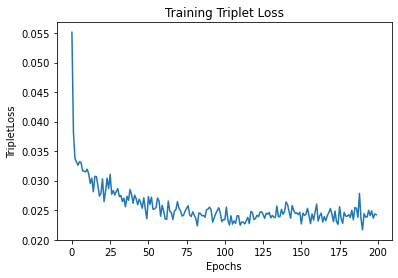

In [17]:
# printing loss function
plt.plot(loss_total)
plt.xlabel("Epochs")
plt.ylabel("TripletLoss")
plt.title("Training Triplet Loss")
plt.savefig(f"loss_curves/loss_curve_MTCNN_epoch{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.png")
plt.show()

## Plotting Learning rates with epochs

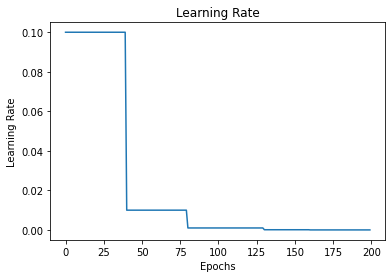

In [18]:
# printing loss function
plt.plot(learning_rates)
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.title("Learning Rate")
plt.savefig(f"loss_curves/learning_curve_MTCNN_epoch{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.png")
plt.show()

In [19]:
model_path = f"models/facenet_model_epochs{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.pth"
if not os.path.exists(model_path):
    torch.save(resnet, model_path)

In [20]:
model_state_path = f"models/facenet_model_statedict_epochs{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.pth"
if not os.path.exists(model_state_path):
    torch.save(resnet.state_dict(), model_state_path)

In [21]:
# resnet = torch.load(model_path)

## Testing the trained model:

In [22]:
resnet.eval().to(device)

test_anchor, test_pos, test_neg, anchor_label = celeba_dataset[1]
# test_anchor, test_pos, test_neg, anchor_label = test_anchor[1], test_pos[1], test_neg[1], anchor_label[1]

test_anchor_emb = resnet(test_anchor[None, :].to(device))
test_pos_emb = resnet(test_pos[None, :].to(device))
test_neg_emb = resnet(test_neg[None, :].to(device))

pos_dist = criterion.cal_distance(test_anchor_emb, test_pos_emb)
neg_dist = criterion.cal_distance(test_anchor_emb, test_neg_emb)

print("The distance between anchor and positive: {}".format(pos_dist[0]))
print("The distance between anchor and negative: {}".format(neg_dist[0]))

The distance between anchor and positive: 0.7975307106971741
The distance between anchor and negative: 1.6744632720947266


In [23]:
test_anchor_emb.shape

torch.Size([1, 512])

## Accuracy of the model

In [24]:
celeba_dataset.train_df.head()

,file_name,person_id,is_train
0,000001.jpg,2880,1
1,000002.jpg,2937,1
2,000003.jpg,8692,1
3,000004.jpg,5805,1
4,000005.jpg,9295,1


In [25]:
celeba_dataset.train_df.iloc[0]["file_name"]

'000001.jpg'

## Creating Vault folder and vault mapping file

In [46]:
vault_path = "data/oneshot_vault"
label_file = "data/identity_vault_person.txt"

In [48]:
# creating the vault and test label file
if not os.path.exists(vault_path):
    os.makedirs(vault_path)

    # copying train images in the vault location and appending the label file
    with open(label_file, "w") as v_file:
        for i in range(len(celeba_dataset.train_df)):
            file = celeba_dataset.train_df.iloc[i]["file_name"]
            label = str(celeba_dataset.train_df.iloc[i]["person_id"])
            v_file.write(file+" "+label+"\n")

            # copying the file to the new folder
            src_file = os.path.join(img_folder, file)
            dst_file = os.path.join(vault_path, file)
            shutil.copy(src_file, dst_file)
        

### Creating vault embeddings or load vault embeddings if already created

In [55]:
# function to create embeddings    
def create_embeddings(celeba_dataloader, model):
    # initializing embedding vector and gt_label list
    embeddings = torch.tensor([])
    gt_labels = []
    
    # creating embeddings 
    for step, (anchors, labels) in enumerate(tqdm(celeba_dataloader, 
                                                            desc="Training", position=1)):
        anchors = anchors.to(device)
        img_embs = model(anchors).detach().cpu()
        
        embeddings = torch.cat([embeddings, img_embs])
        gt_labels.extend(labels)

    return embeddings, gt_labels

In [56]:
vault_embeddings_file = f"pytorch_objects/vault_embeddings_epochs{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.pickle"
vault_gt_labels_file = f"pytorch_objects/vault_gt_labels_epochs{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.pickle"

# setting model to eval mode
resnet.eval().to(device)

if not os.path.exists(vault_embeddings_file) or not os.path.exists(vault_gt_labels_file):
    embeddings, gt_labels = create_embeddings(celeba_dataloader = celeba_dataloader,
                                              model = resnet)
    
    torch.save(embeddings, vault_embeddings_file)
    torch.save(gt_labels, vault_gt_labels_file)
else:
    embeddings = torch.load(vault_embeddings_file)
    gt_labels = torch.load(vault_gt_labels_file)

Training:   0%|          | 0/1502 [00:00<?, ?it/s]

In [57]:
%%time
from sklearn.neighbors import KNeighborsClassifier
embeddings = embeddings.detach().cpu()
# gt_labels = gt_labels.detach().cpu()
gt_labels = torch.tensor(gt_labels)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(embeddings, gt_labels)
# score = knn.score(test_embeddings, test_labels)

# print(f'Pre-trained model: Accuracy = {score}.')

CPU times: user 228 ms, sys: 3.9 ms, total: 232 ms
Wall time: 231 ms


KNeighborsClassifier(n_neighbors=1)

In [60]:
celeba_dataset.train_df.shape

(10157, 3)

In [61]:
# Test image:

def calculate_label(test_images, embeddings, gt_labels, embedding_model):
    # test_image_file = "s1_9.pgm"
    test_images = test_images.to(device)

    test_img_emb = embedding_model(test_images).detach().cpu()
    test_img_emb = test_img_emb[None,:].transpose(2,1).to(device)

    distance_mat = (test_img_emb - embeddings).pow(2).sum(axis=1).transpose(1,0)
    test_label_pred = gt_labels[torch.argmin(distance_mat, axis=1)]

    return test_label_pred


In [62]:
gt_labels.device

device(type='cpu')

In [64]:
torch.is_tensor(gt_labels)

True

In [69]:
celeba_dataset.is_train = False

test_predictions = torch.tensor([]).type(torch.int)
test_gt_labels = torch.tensor([]).type(torch.int)

test_embeddings = torch.tensor([])

# if not torch.is_tensor(gt_labels):
#     gt_labels = torch.tensor(gt_labels).to(device)
# else:
#     gt_labels = gt_labels.to(device)
gt_labels = gt_labels.detach().cpu()

# embeddings_ = embeddings[:, :, None].to(device)

for i, (test_imgs, test_labels) in enumerate(tqdm(celeba_dataloader, 
                                desc="Training", position=1, leave=False)):
    test_gt_labels = torch.cat([test_gt_labels, test_labels])
    
    #new
    test_imgs = test_imgs.to(device)
    test_embs = resnet(test_imgs).detach().cpu()
    test_embeddings = torch.cat([test_embeddings, test_embs])
    
#     test_pred_labels = calculate_label(test_images = test_imgs, embeddings = embeddings_,
#                                        gt_labels=gt_labels, embedding_model=resnet).detach().cpu()
    
#     test_predictions = torch.cat([test_predictions, test_pred_labels])
    
#     if i>200:
#         break

Training:   0%|          | 0/1502 [00:00<?, ?it/s]

In [70]:
test_embeddings_file = f"pytorch_objects/test_embeddings_epochs_epochs{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.pickle"
test_gt_labels_file = f"pytorch_objects/test_gt_labels_epochs{epochs}_margin{margin}_lr{lr}_schedule{str_schedule}.pickle"

if not os.path.exists(test_embeddings_file) or not os.path.exists(test_gt_labels_file):
    torch.save(test_embeddings, test_embeddings_file)
    torch.save(test_gt_labels, test_gt_labels_file)
# test_embeddings = torch.load(test_embeddings_file)
# test_gt_labels = torch.load(test_gt_labels_file)

In [71]:
score = knn.score(test_embeddings, test_gt_labels)

print(f'trained model: Accuracy = {score}.')

trained model: Accuracy = 0.9997605850053348.


In [75]:
test_embeddings.shape

torch.Size([192135, 512])

In [44]:
test_gt_labels[:10]

tensor([1058, 4407, 3602, 3422, 4960, 7434, 4960,  290, 2522,  167])

In [76]:
knn.predict(test_embeddings[:10])

array([1058, 4407, 3602, 3422, 4960, 7434, 4960,  290, 2522,  167])